### Setup

In [5]:
# install if not yet done
using Pkg

# Pkg.add(url="https://github.com/mppmu/BoostFractor.jl.git")
# Pkg.add(url="https://github.com/bergermann/Dragoon.jl.git")
Pkg.update()

    Updating registry at `C:\Users\domin\.julia\registries\General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
    Updating git-repo `https://github.com/mppmu/BoostFractor.jl.git`
  No Changes to `C:\Users\domin\OneDrive\Desktop\Julia Files\Dragoon.jl\Project.toml`
  No Changes to `C:\Users\domin\OneDrive\Desktop\Julia Files\Dragoon.jl\Manifest.toml`


In [25]:
using Dragoon
using Plots

In [55]:
n = 20 # number of discs in the booster

initdist = findpeak1d(20.025e9,n) # initial disc configuration

freqs = genFreqs(20.025e9,50e6; n=10) # optimize on these frequencies
freqsplot = genFreqs(20.025e9,150e6; n=1000) # plot with these frequencies

booster = AnalyticalBooster(initdist; ndisk=n)  # physical properties of the booster

obj = ObjAnalytical

hist = initHist(booster,2*(booster.ndisk^2),freqs,obj);

### Optimizer

In [56]:
trace = nelderMead(booster,hist,freqs,
                    1.,1+2/n,0.75-1/2n,1-1/n,1e-12,
                    obj,
                    InitSimplexRegular(1e-4),
                    DefaultSimplexSampler,
                    UnstuckDont;
                    maxiter=Int(1e5),
                    showtrace=true,
                    showevery=10000,
                    unstuckisiter=true,);

Iter: 10000, timestamp: 9 minutes, 19 seconds
Iter finished. Objective value: -13079.381

Iter: 20000, timestamp: 9 minutes, 26 seconds
Iter finished. Objective value: -13125.782

Minimum simplex size reached.
No unstucking tried. Terminating.
Terminated. 20391 Iterations.
Final objective value: -13126.469
Elapsed movement time:  9 minutes, 26 seconds
Summed distance:   0.37
Elapsed computing time: 8 seconds, 135 milliseconds


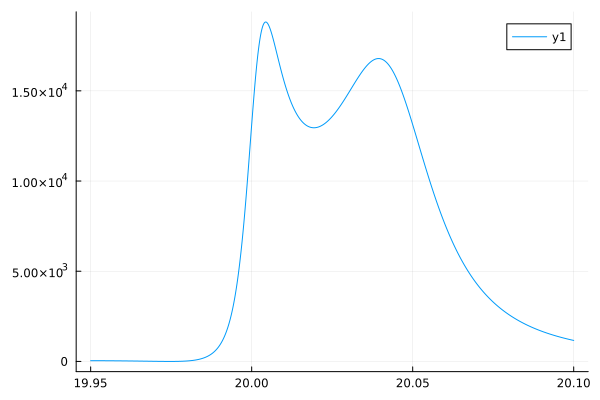

In [57]:
p0 = copy(booster.pos)

plot(freqsplot/1e9,getBoost1d(booster,freqsplot))

In [58]:
freqs1 = collect(range(20.05e9,20.10e9,10))

scale = freqs[1]/(freqs[1]+50e6)

0.9975062344139651

step:  0/100
scale: 0.5
sum:   103304.04532399923
step:  1/100
scale: 0.515
sum:   104622.33433873508
step:  2/100
scale: 0.53
sum:   105916.76203768222
step:  3/100
scale: 0.545
sum:   107188.25953320567
step:  4/100
scale: 0.56
sum:   108437.83209951979
step:  5/100
scale: 0.575
sum:   109666.55493998554
step:  6/100
scale: 0.59
sum:   110875.57044587973
step:  7/100
scale: 0.605
sum:   112066.08692001377
step:  8/100
scale: 0.62
sum:   113239.37874225617
step:  9/100
scale: 0.635
sum:   114396.78795613226
step:  10/100
scale: 0.65
sum:   115539.72725429473
step:  11/100
scale: 0.665
sum:   116669.68433003363
step:  12/100
scale: 0.6799999999999999
sum:   117788.22754140082
step:  13/100
scale: 0.6950000000000001
sum:   118897.01280232095
step:  14/100
scale: 0.71
sum:   119997.79156568788
step:  15/100
scale: 0.725
sum:   121092.4196955726
step:  16/100
scale: 0.74
sum:   122182.866917137
step:  17/100
scale: 0.755
sum:   123271.2263783053
step:  18/100
scale: 0.77
sum:   124359.723

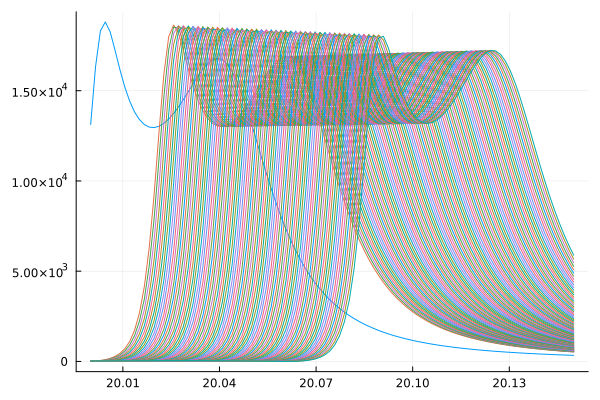

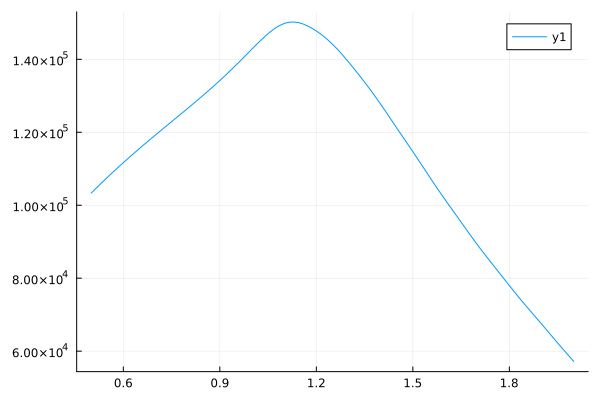

In [69]:
move(booster,p0; additive=false)

rescale(booster,hist,freqs1,obj,scale,(0.5,2.),100)

In [68]:


function rescale(booster::Booster,hist::Vector{State},freqs::Array{Float64},obj::Callback,
        scale::Float64,scalerange::Tuple{Float64,Float64},scalesteps::Int)

    p0 = copy(booster.pos)
    dd = (scale-1)*pos2dist(booster.pos; disk_thickness=booster.thickness)

    b_ = 0; B = zeros(Float64,scalesteps+1)
    i_ = 0

    freqsplot = collect(range(2*freqs[1]-freqs[end],2*freqs[end]-freqs[1],100))

    p = plot(freqsplot/1e9,getBoost1d(booster,freqsplot),legend=false)

    for i in 0:scalesteps
        move(booster,dist2pos(pos2dist(p0)+dd*Dragoon.lerp(scalerange,i/scalesteps)))
        updateHist!(booster,hist,freqs,obj)
        
        b = sum(getBoost1d(booster,freqs))
        B[i+1] = b

        if b > b_
            b_ = b
            i_ = i
        end

        println("step:  ",i,"/",scalesteps)
        println("scale: ",Dragoon.lerp(scalerange,i/scalesteps))
        println("sum:   ",b)

        plot!(p,freqsplot/1e9,getBoost1d(booster,freqsplot))
    end

    display(p)
    display(plot(Dragoon.lerp.(scalerange[1],scalerange[2],(0:scalesteps)./scalesteps),B))

    move(booster,p0+dd*Dragoon.lerp(scalerange,i_/scalesteps))

    return
end

rescale (generic function with 1 method)